In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import hdbscan
% matplotlib inline

In [2]:
# train = pd.read_csv('../data/train.csv')
train = pd.read_csv('~/Dropbox/DSI/train.csv')
cols = [i for i in train.columns]
train.Date = pd.to_datetime(train.Date)

# rename the extra trap
train.loc[test['Coordinates'] == (41.992478000000006, -87.862994999999998), 'Trap'] = 'T009Alt'
train.loc[test['Coordinates'] == (41.763733000000002, -87.742301999999995) , 'Trap'] = 'T035Alt'


# deal with NaNs
for i in train.columns[train.isnull().sum()>0]: # for all the columns with nans
    mean_avg_temp = train.loc[train[i].isnull()==True,'Tavg'].mean() # what is the mean Tavg
    mean_i_val = train.loc[train.Tavg==mean_avg_temp,i].mean() # what is i val for that Tavg
    train.loc[train[i].isnull()==True,'to_fill'] = mean_i_val
    train[i] = train[i].fillna(train.to_fill)
    train.drop('to_fill',axis=1,inplace=True)

# remove date columns
dates = ['_date-'+str(i) for i in range(1,7)]
for i,v in enumerate(cols):
    try:
        if v in dates: # drops out the repeated date column
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    try:
        if 'Date_date-' in v:
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    
# label encode Species and Trap
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
le = LabelEncoder()
le.fit(train.Species)
train['mosquito'] = le.transform(train.Species)
le.fit(train.Trap)
train['trap_e'] = le.transform(train.Trap)
cols = [i for i in train.columns]
X_cols = cols[13:]
X_cols.append('Latitude')
X_cols.append('Longitude')
X_cols.append('AddressAccuracy')
# X_cols.append('NumMosquitos')

# set up y
y = train.dropna()['WnvPresent']

# set up and standardize X
X_values = train[X_cols].dropna().values # convert to numpy array
ss = StandardScaler()
X_std = ss.fit_transform(X_values)

In [122]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(m):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=7)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
#     print "Predicted Totals:"
#     for i,v in enumerate(np.bincount(y)):
#         print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [126]:
train[train.Trap == 'T035'].Coordinates.value_counts()

(41.763733000000002, -87.742301999999995)    45
(41.836644, -87.677736999999993)             27
Name: Coordinates, dtype: int64

In [147]:
test = pd.read_csv('../data/input/test.csv')
species = set(test.Species)
species = [i for i in species]
species_labels = {}
for i,v in enumerate(species):
    species_labels[v] = i
train['species_labels'] = train['Species'].map(species_labels)

# HDBSCAN

In [115]:
from sklearn.metrics import silhouette_score
X = train[X_cols].dropna()
X_vals = X.values
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
cluster_labels = clusterer.fit_predict(X)
print "Silhouette",silhouette_score(X,cluster_labels)
                                       
# train.dropna()['cluster_labels'] = clusterer.labels_
cluster = train[X_cols].dropna()
cluster['cluster_labels'] = cluster_labels
np.append(X_vals,cluster_labels)

Silhouette 0.893895851486


array([  1.        ,  13.96500432,   6.19448679, ...,  27.        ,
        27.        ,  27.        ])

In [116]:
# We create a total of ... 665 clusters. That's a lot of clusters. Reran with min clusters=10/20
cluster_labels.max()

104

In [118]:
pd.crosstab(cluster.cluster_labels,train.WnvPresent)

WnvPresent,0,1
cluster_labels,,
-1.0,174,20
0.0,25,0
1.0,60,0
2.0,62,0
3.0,183,2
4.0,26,0
5.0,54,1
6.0,107,0
7.0,146,0


In [124]:
X_values = cluster.drop('cluster_labels',axis=1).values
ss = StandardScaler()
X_std = ss.fit_transform(X_values)
X = X_std
y = cluster['cluster_labels']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33)

In [125]:
rf = RandomForestClassifier()
evaluate_model(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	1.0 


Cross Val Scores: [ 0.97797063  0.98719677  0.99317872  0.9917639   0.98821082  0.9993007
  0.96246459] 

Cross Val mean ± Std. Dev:0.986 


Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           20            0
Actual 0            0            8 

Classification Report:


IndexError: list index out of range

## Non-PCA section

In [30]:
# X for train test split (non-PCA)
X = X_std
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.94 


Cross Val Scores: [ 0.93136582  0.48387097  0.85498282  0.91546392  0.83436426  0.81168385
  0.62817869] 

Cross Val mean ± Std. Dev:0.78 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           25          149
Actual 0           53         3136 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      3189
          1       0.32      0.14      0.20       174

avg / total       0.92      0.94      0.93      3363



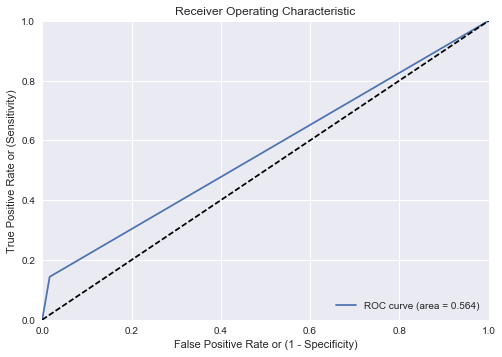

In [79]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
evaluate_model(clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.939 


Cross Val Scores: [ 0.94783802  0.63761153  0.91340206  0.94845361  0.90034364  0.89621993
  0.77594502] 

Cross Val mean ± Std. Dev:0.86 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           38          136
Actual 0           68         3121 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       

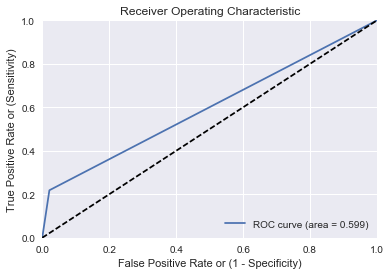

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
clf = AdaBoostClassifier(base_estimator=rf)
evaluate_model(clf)

In [68]:
train[X_cols].head()

,Weather_Station,T152_dist,T153_dist,T019_dist,T018_dist,T156_dist,T157_dist,T154_dist,T155_dist,T013_dist,...,SN_date-6,Trap_Mosquitos_today,Trap_Species_today,min_Wnv_species_today,Epoch,mosquito,trap_e,Latitude,Longitude,AddressAccuracy
0,1,13.965004,6.194487,8.496345,13.042652,20.840800,18.071554,5.675603,19.935975,3.678630,...,0,2,1,0,1180396800,2,1,41.954690,-87.800991,9
1,1,13.965004,6.194487,8.496345,13.042652,20.840800,18.071554,5.675603,19.935975,3.678630,...,0,2,1,0,1180396800,3,1,41.954690,-87.800991,9
2,1,17.129532,9.737201,7.713386,9.017476,24.819798,20.590963,8.597630,24.346446,8.032792,...,0,1,1,0,1180396800,3,6,41.994991,-87.769279,9
3,1,16.831087,9.085275,10.790069,14.037464,23.452451,20.983837,8.594262,22.334626,6.483080,...,0,5,1,0,1180396800,2,14,41.974089,-87.824812,8
4,1,16.831087,9.085275,10.790069,14.037464,23.452451,20.983837,8.594262,22.334626,6.483080,...,0,5,4,0,1180396800,3,14,41.974089,-87.824812,8


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 

Accuracy Score:	0.974 


Cross Val Scores: [ 0.97323267  0.77076184  0.96013746  0.97250859  0.95257732  0.96975945
  0.92989691] 

Cross Val mean ± Std. Dev:0.933 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1          115           59
Actual 0           30         3159 

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3189
          1       0.79      0.66      0.72       174

avg / total       0.97      0.97      0.97    

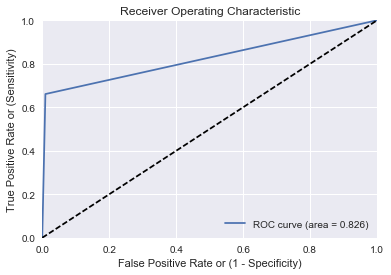

In [49]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
clf = GradientBoostingClassifier()
evaluate_model(clf)


In [54]:
from sklearn.externals import joblib
joblib.dump(clf,'../models/grad_boost_426.pkl')

['../models/grad_boost_426.pkl']

In [63]:
X_values

array([[  1.        ,  13.96500432,   6.19448679, ...,  41.95469   ,
        -87.800991  ,   9.        ],
       [  1.        ,  13.96500432,   6.19448679, ...,  41.95469   ,
        -87.800991  ,   9.        ],
       [  1.        ,  17.12953196,   9.73720078, ...,  41.994991  ,
        -87.769279  ,   9.        ],
       ..., 
       [  2.        ,   9.40668756,  16.07617966, ...,  41.763733  ,
        -87.742302  ,   8.        ],
       [  2.        ,   8.4022005 ,   7.70125821, ...,  41.912563  ,
        -87.668055  ,   9.        ],
       [  2.        ,  10.70538984,  18.32266624, ...,  41.776428  ,
        -87.627096  ,   8.        ]])

In [64]:
X_values = train[X_cols].dropna()

In [66]:
X_values.columns

Index([u'Weather_Station', u'T152_dist', u'T153_dist', u'T019_dist',
       u'T018_dist', u'T156_dist', u'T157_dist', u'T154_dist', u'T155_dist',
       u'T013_dist',
       ...
       u'SN_date-6', u'Trap_Mosquitos_today', u'Trap_Species_today',
       u'min_Wnv_species_today', u'Epoch', u'mosquito', u'trap_e', u'Latitude',
       u'Longitude', u'AddressAccuracy'],
      dtype='object', length=593)

In [81]:
test_cols = ['Weather_Station', 'T152_dist', 'T153_dist', 'T019_dist', 'T018_dist', 'T156_dist', 'T157_dist', 'T154_dist', 'T155_dist', 'T013_dist', 'T012_dist', 'T011_dist', 'T159_dist', 'T017_dist', 'T016_dist', 'T015_dist', 'T014_dist', 'T151_dist', 'T080_dist', 'T081_dist', 'T082_dist', 'T083_dist', 'T084_dist', 'T085_dist', 'T086_dist', 'T090A_dist', 'T088_dist', 'T089_dist', 'T090C_dist', 'T218B_dist', 'T158_dist', 'T218A_dist', 'T149_dist', 'T148_dist', 'T009Alt_dist', 'T145_dist', 'T144_dist', 'T147_dist', 'T146_dist', 'T141_dist', 'T143_dist', 'T142_dist', 'T128A_dist', 'T903_dist', 'T092_dist', 'T091_dist', 'T090_dist', 'T097_dist', 'T096_dist', 'T095_dist', 'T094_dist', 'T099_dist', 'T222_dist', 'T138_dist', 'T046_dist', 'T128_dist', 'T002B_dist', 'T114_dist', 'T002A_dist', 'T027_dist', 'T090B_dist', 'T025_dist', 'T228_dist', 'T229_dist', 'T900_dist', 'T224_dist', 'T225_dist', 'T226_dist', 'T227_dist', 'T220_dist', 'T221_dist', 'T028_dist', 'T223_dist', 'T044_dist', 'T045_dist', 'T129_dist', 'T047_dist', 'T040_dist', 'T043_dist', 'T048_dist', 'T049_dist', 'T065A_dist', 'T035Alt_dist', 'T031_dist', 'T030_dist', 'T033_dist', 'T035_dist', 'T034_dist', 'T037_dist', 'T036_dist', 'T039_dist', 'T236_dist', 'T235_dist', 'T234_dist', 'T233_dist', 'T232_dist', 'T231_dist', 'T230_dist', 'T054_dist', 'T051_dist', 'T050_dist', 'T209_dist', 'T200_dist', 'T206_dist', 'T062_dist', 'T063_dist', 'T060_dist', 'T061_dist', 'T066_dist', 'T067_dist', 'T065_dist', 'T069_dist', 'T135_dist', 'T054C_dist', 'T238_dist', 'T215_dist', 'T212_dist', 'T219_dist', 'T218_dist', 'T218C_dist', 'T150_dist', 'T115_dist', 'T200B_dist', 'T200A_dist', 'T079_dist', 'T078_dist', 'T075_dist', 'T074_dist', 'T077_dist', 'T076_dist', 'T071_dist', 'T070_dist', 'T073_dist', 'T072_dist', 'T094B_dist', 'T100_dist', 'T103_dist', 'T102_dist', 'T107_dist', 'T008_dist', 'T009_dist', 'T162_dist', 'T161_dist', 'T160_dist', 'T001_dist', 'T002_dist', 'T003_dist', 'T004_dist', 'T005_dist', 'T006_dist', 'T007_dist', 'T237_dist', 'T152_bearing', 'T153_bearing', 'T019_bearing', 'T018_bearing', 'T156_bearing', 'T157_bearing', 'T154_bearing', 'T155_bearing', 'T013_bearing', 'T012_bearing', 'T011_bearing', 'T159_bearing', 'T017_bearing', 'T016_bearing', 'T015_bearing', 'T014_bearing', 'T151_bearing', 'T080_bearing', 'T081_bearing', 'T082_bearing', 'T083_bearing', 'T084_bearing', 'T085_bearing', 'T086_bearing', 'T090A_bearing', 'T088_bearing', 'T089_bearing', 'T090C_bearing', 'T218B_bearing', 'T158_bearing', 'T218A_bearing', 'T149_bearing', 'T148_bearing', 'T009Alt_bearing', 'T145_bearing', 'T144_bearing', 'T147_bearing', 'T146_bearing', 'T141_bearing', 'T143_bearing', 'T142_bearing', 'T128A_bearing', 'T903_bearing', 'T092_bearing', 'T091_bearing', 'T090_bearing', 'T097_bearing', 'T096_bearing', 'T095_bearing', 'T094_bearing', 'T099_bearing', 'T222_bearing', 'T138_bearing', 'T046_bearing', 'T128_bearing', 'T002B_bearing', 'T114_bearing', 'T002A_bearing', 'T027_bearing', 'T090B_bearing', 'T025_bearing', 'T228_bearing', 'T229_bearing', 'T900_bearing', 'T224_bearing', 'T225_bearing', 'T226_bearing', 'T227_bearing', 'T220_bearing', 'T221_bearing', 'T028_bearing', 'T223_bearing', 'T044_bearing', 'T045_bearing', 'T129_bearing', 'T047_bearing', 'T040_bearing', 'T043_bearing', 'T048_bearing', 'T049_bearing', 'T065A_bearing', 'T035Alt_bearing', 'T031_bearing', 'T030_bearing', 'T033_bearing', 'T035_bearing', 'T034_bearing', 'T037_bearing', 'T036_bearing', 'T039_bearing', 'T236_bearing', 'T235_bearing', 'T234_bearing', 'T233_bearing', 'T232_bearing', 'T231_bearing', 'T230_bearing', 'T054_bearing', 'T051_bearing', 'T050_bearing', 'T209_bearing', 'T200_bearing', 'T206_bearing', 'T062_bearing', 'T063_bearing', 'T060_bearing', 'T061_bearing', 'T066_bearing', 'T067_bearing', 'T065_bearing', 'T069_bearing', 'T135_bearing', 'T054C_bearing', 'T238_bearing', 'T215_bearing', 'T212_bearing', 'T219_bearing', 'T218_bearing', 'T218C_bearing', 'T150_bearing', 'T115_bearing', 'T200B_bearing', 'T200A_bearing', 'T079_bearing', 'T078_bearing', 'T075_bearing', 'T074_bearing', 'T077_bearing', 'T076_bearing', 'T071_bearing', 'T070_bearing', 'T073_bearing', 'T072_bearing', 'T094B_bearing', 'T100_bearing', 'T103_bearing', 'T102_bearing', 'T107_bearing', 'T008_bearing', 'T009_bearing', 'T162_bearing', 'T161_bearing', 'T160_bearing', 'T001_bearing', 'T002_bearing', 'T003_bearing', 'T004_bearing', 'T005_bearing', 'T006_bearing', 'T007_bearing', 'T237_bearing', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'HZ', 'VA', 'VC', 'GS', 'GR', 'FG\\+', 'BC', 'BL', 'FZ', 'UP', 'FC', 'DZ', 'BR', 'FG', 'IC', 'DU', 'DR', 'DS', 'FU', 'PR', 'SS', 'SQ', 'PY', 'MI', 'TS', 'SH', 'RA', '\\+FC', 'SA', 'SG', 'PO', 'PL', 'SN', 'Tmax_date-1', 'Tmin_date-1', 'Tavg_date-1', 'DewPoint_date-1', 'WetBulb_date-1', 'PrecipTotal_date-1', 'StnPressure_date-1', 'SeaLevel_date-1', 'ResultSpeed_date-1', 'ResultDir_date-1', 'AvgSpeed_date-1', 'HZ_date-1', 'VA_date-1', 'VC_date-1', 'GS_date-1', 'GR_date-1', 'FG\\+_date-1', 'BC_date-1', 'BL_date-1', 'FZ_date-1', 'UP_date-1', 'FC_date-1', 'DZ_date-1', 'BR_date-1', 'FG_date-1', 'IC_date-1', 'DU_date-1', 'DR_date-1', 'DS_date-1', 'FU_date-1', 'PR_date-1', 'SS_date-1', 'SQ_date-1', 'PY_date-1', 'MI_date-1', 'TS_date-1', 'SH_date-1', 'RA_date-1', '\\+FC_date-1', 'SA_date-1', 'SG_date-1', 'PO_date-1', 'PL_date-1', 'SN_date-1', 'Tmax_date-2', 'Tmin_date-2', 'Tavg_date-2', 'DewPoint_date-2', 'WetBulb_date-2', 'PrecipTotal_date-2', 'StnPressure_date-2', 'SeaLevel_date-2', 'ResultSpeed_date-2', 'ResultDir_date-2', 'AvgSpeed_date-2', 'HZ_date-2', 'VA_date-2', 'VC_date-2', 'GS_date-2', 'GR_date-2', 'FG\\+_date-2', 'BC_date-2', 'BL_date-2', 'FZ_date-2', 'UP_date-2', 'FC_date-2', 'DZ_date-2', 'BR_date-2', 'FG_date-2', 'IC_date-2', 'DU_date-2', 'DR_date-2', 'DS_date-2', 'FU_date-2', 'PR_date-2', 'SS_date-2', 'SQ_date-2', 'PY_date-2', 'MI_date-2', 'TS_date-2', 'SH_date-2', 'RA_date-2', '\\+FC_date-2', 'SA_date-2', 'SG_date-2', 'PO_date-2', 'PL_date-2', 'SN_date-2', 'Tmax_date-3', 'Tmin_date-3', 'Tavg_date-3', 'DewPoint_date-3', 'WetBulb_date-3', 'PrecipTotal_date-3', 'StnPressure_date-3', 'SeaLevel_date-3', 'ResultSpeed_date-3', 'ResultDir_date-3', 'AvgSpeed_date-3', 'HZ_date-3', 'VA_date-3', 'VC_date-3', 'GS_date-3', 'GR_date-3', 'FG\\+_date-3', 'BC_date-3', 'BL_date-3', 'FZ_date-3', 'UP_date-3', 'FC_date-3', 'DZ_date-3', 'BR_date-3', 'FG_date-3', 'IC_date-3', 'DU_date-3', 'DR_date-3', 'DS_date-3', 'FU_date-3', 'PR_date-3', 'SS_date-3', 'SQ_date-3', 'PY_date-3', 'MI_date-3', 'TS_date-3', 'SH_date-3', 'RA_date-3', '\\+FC_date-3', 'SA_date-3', 'SG_date-3', 'PO_date-3', 'PL_date-3', 'SN_date-3', 'Tmax_date-4', 'Tmin_date-4', 'Tavg_date-4', 'DewPoint_date-4', 'WetBulb_date-4', 'PrecipTotal_date-4', 'StnPressure_date-4', 'SeaLevel_date-4', 'ResultSpeed_date-4', 'ResultDir_date-4', 'AvgSpeed_date-4', 'HZ_date-4', 'VA_date-4', 'VC_date-4', 'GS_date-4', 'GR_date-4', 'FG\\+_date-4', 'BC_date-4', 'BL_date-4', 'FZ_date-4', 'UP_date-4', 'FC_date-4', 'DZ_date-4', 'BR_date-4', 'FG_date-4', 'IC_date-4', 'DU_date-4', 'DR_date-4', 'DS_date-4', 'FU_date-4', 'PR_date-4', 'SS_date-4', 'SQ_date-4', 'PY_date-4', 'MI_date-4', 'TS_date-4', 'SH_date-4', 'RA_date-4', '\\+FC_date-4', 'SA_date-4', 'SG_date-4', 'PO_date-4', 'PL_date-4', 'SN_date-4', 'Tmax_date-5', 'Tmin_date-5', 'Tavg_date-5', 'DewPoint_date-5', 'WetBulb_date-5', 'PrecipTotal_date-5', 'StnPressure_date-5', 'SeaLevel_date-5', 'ResultSpeed_date-5', 'ResultDir_date-5', 'AvgSpeed_date-5', 'HZ_date-5', 'VA_date-5', 'VC_date-5', 'GS_date-5', 'GR_date-5', 'FG\\+_date-5', 'BC_date-5', 'BL_date-5', 'FZ_date-5', 'UP_date-5', 'FC_date-5', 'DZ_date-5', 'BR_date-5', 'FG_date-5', 'IC_date-5', 'DU_date-5', 'DR_date-5', 'DS_date-5', 'FU_date-5', 'PR_date-5', 'SS_date-5', 'SQ_date-5', 'PY_date-5', 'MI_date-5', 'TS_date-5', 'SH_date-5', 'RA_date-5', '\\+FC_date-5', 'SA_date-5', 'SG_date-5', 'PO_date-5', 'PL_date-5', 'SN_date-5', 'Tmax_date-6', 'Tmin_date-6', 'Tavg_date-6', 'DewPoint_date-6', 'WetBulb_date-6', 'PrecipTotal_date-6', 'StnPressure_date-6', 'SeaLevel_date-6', 'ResultSpeed_date-6', 'ResultDir_date-6', 'AvgSpeed_date-6', 'HZ_date-6', 'VA_date-6', 'VC_date-6', 'GS_date-6', 'GR_date-6', 'FG\\+_date-6', 'BC_date-6', 'BL_date-6', 'FZ_date-6', 'UP_date-6', 'FC_date-6', 'DZ_date-6', 'BR_date-6', 'FG_date-6', 'IC_date-6', 'DU_date-6', 'DR_date-6', 'DS_date-6', 'FU_date-6', 'PR_date-6', 'SS_date-6', 'SQ_date-6', 'PY_date-6', 'MI_date-6', 'TS_date-6', 'SH_date-6', 'RA_date-6', '\\+FC_date-6', 'SA_date-6', 'SG_date-6', 'PO_date-6', 'PL_date-6', 'SN_date-6', 'Epoch', 'mosquito', 'trap_e']

In [76]:
X_test_cols = [col for col in train.columns if col in test_cols]
len(X_test_cols)

587

In [77]:
X_values = train[X_test_cols].dropna().values
ss = StandardScaler()
X_std = ss.fit_transform(X_values)
X = X_std
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False) 

Accuracy Score:	0.944 


Cross Val Scores: [ 0.94783802  0.23335621  0.63436426  0.94845361  0.6556701   0.4790378
  0.11477663] 

Cross Val mean ± Std. Dev:0.573 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           12          162
Actual 0           25         3164 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      3189
          1       0.32      0.07      0.11       174

avg / total       0.92      0.94      0.93     

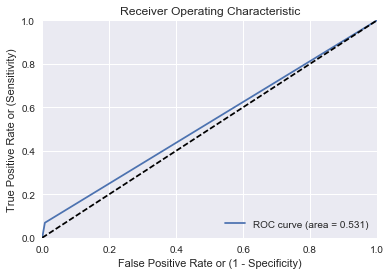

In [78]:
evaluate_model(clf)

In [81]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [82]:
features = pd.DataFrame({'Feature':train[X_cols].columns,
                         'Importance':np.round(rf.feature_importances_,6)})
features.sort_values(by='Importance',ascending=False)

,Feature,Importance
584,mosquito,0.196802
547,SeaLevel_date-6,0.011715
458,StnPressure_date-4,0.010052
323,DewPoint_date-1,0.009807
415,SeaLevel_date-3,0.009303
412,WetBulb_date-3,0.008983
329,ResultDir_date-1,0.008431
322,Tavg_date-1,0.008258
374,AvgSpeed_date-2,0.007928
414,StnPressure_date-3,0.007764


## PCA

In [76]:
# PCA, remember to run in this section before you run the below.
from sklearn.decomposition import PCA
pca = PCA(n_components=31,svd_solver='full') # 30 components describe 85% of variance
pca.fit(X)
X_pca = pca.transform(X)
# print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,stratify=y, test_size=0.33)

0.85528346836


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.942 


Cross Val Scores: [ 0.94783802  0.23335621  0.70790378  0.94845361  0.52508591  0.46872852
  0.29003436] 

Cross Val mean ± Std. Dev:0.589 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           26          148
Actual 0           48         3141 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.35      0.15      0.21       174

avg / total       0.92      0.94      0.93      3363



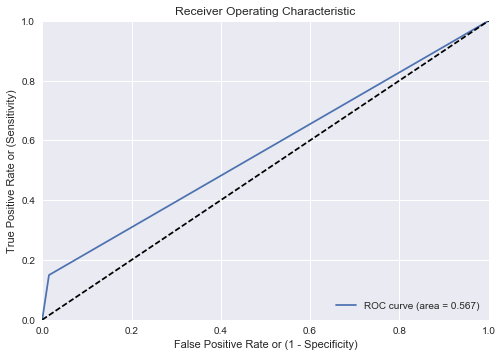

In [77]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=.8)
evaluate_model(clf)